# COVID-19 Pandemic Prediction 

Predicting the number of positive cases in the Philippines and also the health equipment found in hospitals (Logistic Regression). Also predict the health status of a patient using demographic characteristics (Naive Bayes).

## Imports

In [2]:
!pip install imbalanced-learn

  Using cached imbalanced_learn-0.10.0-py3-none-any.whl (225 kB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [2]:
##### Standard Libraries #####
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from numpy import log, dot, e
from math import sqrt
sns.set_style("whitegrid")
sns.set_context("poster")

%matplotlib inline

##### For Preprocessing #####
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler

##### For Building the Model #####
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB
#from sklearn.pipeline import make_pipeline

##### For Validation of the Model #####
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

## Reading Data

In [3]:
df_cases = pd.read_csv('./COVID-19_Cases_in_the_Philippines_Dataset/Testing_Aggregates_20200513.csv')

In [4]:
df_cases

,Date,Name of Health Facility/Laboratory,Abbrev of Health Facility,Daily Output - Positive Individuals,Daily Output - Unique Individuals Tested,Daily Output - Tests Conducted,UNIQUE INDIVIDUALS TESTED,POSITIVE INDIVIDUALS,% positive/ unique individuals,NEGATIVE INDIVIDUALS,% negative/ unique individuals,EQUIVOCAL,% equivocal /unique individuals,INVALID,% invalid /unique individuals,TOTAL TESTS CONDUCTED,REMAINING AVAILABLE TESTS,Unnamed: 17
0,"April 2, 2020",Research Institute for Tropical Medicine (RITM),RITM,NaN,NaN,NaN,"15,197","2,652",17%,"11,367",75%,32,0.20%,NaN,NaN,"20,826","75,396",NaN
1,"April 2, 2020",Baguio General Hospital and Medical Center (BG...,BGHMC,NaN,NaN,NaN,473,21,4%,452,96%,0,0.00%,NaN,NaN,478,"4,519",NaN
2,"April 2, 2020",San Lazaro Hospital (SLH),SLH,NaN,NaN,NaN,115,31,27%,84,73%,0,0.00%,NaN,NaN,193,"4,846",NaN
3,"April 2, 2020",Vicente Sotto Memorial Medical Center (VSMMC),VSMMC,NaN,NaN,NaN,672,37,6%,634,94%,1,0.10%,NaN,NaN,672,"23,812",NaN
4,"April 2, 2020",UP National Institutes of Health (UP-NIH),UP-NIH,NaN,NaN,NaN,332,43,13%,279,84%,10,3.00%,NaN,NaN,335,"4,565",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,"May 12, 2020",Chinese General Hospital (CGH),CGH,22,439,439,"3,272",321,10%,"2,951",90%,0,0.00%,0.0,0.00%,"3,277",-,NaN
652,"May 12, 2020",Philippine Red Cross Logistics & Multipurpose ...,PLMC,30,"2,158","2,158","14,754",538,4%,"14,202",96%,14,0.10%,0.0,0.00%,"14,755",-,NaN
653,"May 12, 2020",Singapore Diagnostics,NaN,8,99,99,351,39,11%,312,89%,0,0.00%,0.0,0.00%,352,"9,069",NaN
654,"May 12, 2020",Lung Center of the Philippines GeneXpert Labor...,NaN,13,42,42,243,47,19%,196,81%,0,0.00%,0.0,0,243,894,NaN


In [90]:
path_isolbed_o = './COVID-19_Cases_in_the_Philippines_Dataset/DOH Data Collect - Daily Reports'
csv_isolbed_o = glob.glob(path_isolbed_o + "/*.csv")
df_list_isolbed_o = (pd.read_csv(file) for file in csv_isolbed_o)

In [91]:
df_isolbed_o = pd.concat(df_list_isolbed_o, ignore_index=True)

In [92]:
df_isolbed_o.columns

Index(['updateddate', 'addeddate', 'reportdate', 'icu_np_o', 'beds_ward_v',
       'isolbed_o', 'icu_wnp_v', 'hfhudcode', 'beds_ward_o', 'id',
       'reporttime', 'icu_np_v', 'mechvent_o', 'mechvent_v', 'isolbed_v',
       'icu_wnp_o', 'cfname', 'er_suspro', 'adm_suspro', 'er_confirm',
       'adm_confirm', 'icu_o', 'icu_v'],
      dtype='object')

In [87]:
path_surgmask = './COVID-19_Cases_in_the_Philippines_Dataset/DOH Data Collect - Weekly Reports'
csv_surgmask = glob.glob(path_surgmask + "/*.csv")
df_list_surgmask = (pd.read_csv(file) for file in csv_surgmask)

In [88]:
df_surgmask = pd.concat(df_list_surgmask, ignore_index=True)

In [89]:
df_surgmask.columns

Index(['updateddate', 'addeddate', 'reportdate', 'goggles', 'mechvent_tech',
       'icu_nurse', 'respthe', 'shoe_cover', 'pulmo', 'medtech', 'gloves',
       'face_shield', 'resident', 'gown', 'hfhudcode', 'ic_specialist',
       'n95mask', 'er_nurse', 'id_specialist', 'ward_nurse', 'id', 'surgmask',
       'head_cover', 'cfname', 'coverall'],
      dtype='object')

In [5]:
df_health_status = pd.read_csv('./COVID-19_Cases_in_the_Philippines_Dataset/Case_Information.csv')

In [6]:
df_health_status.columns

Index(['case_id', 'age', 'age_group', 'sex', 'date_announced',
       'date_recovered', 'date_of_death', 'status',
       'date_announced_as_removed', 'province', 'muni_city', 'health_status',
       'home_quarantined', 'date_of_onset_of_symptoms', 'pregnant', 'region'],
      dtype='object')

## Predict Number of Positive Cases

Use logistic regression to predict the number of <i> positive individuals </i> by finding out which factors have a strong correlation with <i> positive individuals </i>

Steps:
1. Clean data and convert all values to int
2. Create correlation matrix and visualize it. Choose factors with high correlation to <i>POSITIVE INDIVIDUALS</i>
3. Create linear regression model and predict using x_test.
4. Compare y_pred and y_test
5. Evaluate model using R2 and MSE


In [6]:
df_cases.columns

Index(['Date', 'Name of Health Facility/Laboratory',
       'Abbrev of Health Facility', 'Daily Output - Positive Individuals',
       'Daily Output - Unique Individuals Tested ',
       'Daily Output - Tests Conducted', 'UNIQUE INDIVIDUALS TESTED',
       'POSITIVE INDIVIDUALS', '% positive/ unique individuals',
       'NEGATIVE INDIVIDUALS', '% negative/ unique individuals', 'EQUIVOCAL',
       '% equivocal /unique individuals', 'INVALID',
       '% invalid /unique individuals', 'TOTAL TESTS CONDUCTED',
       'REMAINING AVAILABLE TESTS', 'Unnamed: 17'],
      dtype='object')

In [7]:
df_cases = df_cases.drop('Unnamed: 17', axis=1)

In [8]:
df_corr_cases = df_cases.drop(['Date', 'Name of Health Facility/Laboratory',
       'Abbrev of Health Facility', '% positive/ unique individuals', '% negative/ unique individuals', '% equivocal /unique individuals', 
        '% invalid /unique individuals'], axis=1)

In [9]:
# replace NA data with 0
df_corr_cases = df_corr_cases.fillna(0)

In [10]:
# check the types of each column
df_corr_cases.dtypes

Daily Output - Positive Individuals           object
Daily Output - Unique Individuals Tested      object
Daily Output - Tests Conducted                object
UNIQUE INDIVIDUALS TESTED                     object
POSITIVE INDIVIDUALS                          object
NEGATIVE INDIVIDUALS                          object
EQUIVOCAL                                      int64
INVALID                                      float64
TOTAL TESTS CONDUCTED                         object
REMAINING AVAILABLE TESTS                     object
dtype: object

In [11]:
# the numbers in eahc column are in string format with commas. remove commas first to convert str to int
df_corr_cases = df_corr_cases.replace(",", "", regex=True)

In [12]:
# this row has 'NR' as its values so dropped it
df_corr_cases = df_corr_cases.drop(146)

In [13]:
# some rows have '-' as their value in REMAINING AVAILABLE TESTS so replace them with 0
df_corr_cases.loc[df_corr_cases['REMAINING AVAILABLE TESTS'] == '-']

,Daily Output - Positive Individuals,Daily Output - Unique Individuals Tested,Daily Output - Tests Conducted,UNIQUE INDIVIDUALS TESTED,POSITIVE INDIVIDUALS,NEGATIVE INDIVIDUALS,EQUIVOCAL,INVALID,TOTAL TESTS CONDUCTED,REMAINING AVAILABLE TESTS
617,0,8,7,8,0,7,0,1.0,7,-
624,24,366,366,2833,299,2534,0,0.0,2838,-
644,0,16,17,16,0,24,0,0.0,24,-
651,22,439,439,3272,321,2951,0,0.0,3277,-
652,30,2158,2158,14754,538,14202,14,0.0,14755,-


In [14]:
df_corr_cases = df_corr_cases.replace("-", "0")

In [15]:
# now change all values in the dataframe to int
df_corr_cases = df_corr_cases.astype(int)

In [16]:
# types have now changed to int
df_corr_cases.dtypes

Daily Output - Positive Individuals          int32
Daily Output - Unique Individuals Tested     int32
Daily Output - Tests Conducted               int32
UNIQUE INDIVIDUALS TESTED                    int32
POSITIVE INDIVIDUALS                         int32
NEGATIVE INDIVIDUALS                         int32
EQUIVOCAL                                    int32
INVALID                                      int32
TOTAL TESTS CONDUCTED                        int32
REMAINING AVAILABLE TESTS                    int32
dtype: object

In [17]:
# calculate correlation values of each column with each other to find the columns we can use
df_corr_cases.corr()

,Daily Output - Positive Individuals,Daily Output - Unique Individuals Tested,Daily Output - Tests Conducted,UNIQUE INDIVIDUALS TESTED,POSITIVE INDIVIDUALS,NEGATIVE INDIVIDUALS,EQUIVOCAL,INVALID,TOTAL TESTS CONDUCTED,REMAINING AVAILABLE TESTS
Daily Output - Positive Individuals,1.000000,0.658014,0.671802,0.476077,0.514300,0.465780,0.251123,0.081320,0.467161,0.196757
Daily Output - Unique Individuals Tested,0.658014,1.000000,0.990812,0.644753,0.567148,0.655022,0.200055,0.064238,0.625036,0.364163
Daily Output - Tests Conducted,0.671802,0.990812,1.000000,0.701332,0.629663,0.710170,0.212423,0.067451,0.683453,0.377935
UNIQUE INDIVIDUALS TESTED,0.476077,0.644753,0.701332,1.000000,0.970181,0.998950,0.294263,0.068177,0.999053,0.596016
POSITIVE INDIVIDUALS,0.514300,0.567148,0.629663,0.970181,1.000000,0.958205,0.332230,0.059700,0.975383,0.538851
NEGATIVE INDIVIDUALS,0.465780,0.655022,0.710170,0.998950,0.958205,1.000000,0.281079,0.065034,0.996830,0.602826
EQUIVOCAL,0.251123,0.200055,0.212423,0.294263,0.332230,0.281079,1.000000,0.752341,0.290951,0.104416
INVALID,0.081320,0.064238,0.067451,0.068177,0.059700,0.065034,0.752341,1.000000,0.063102,-0.019909
TOTAL TESTS CONDUCTED,0.467161,0.625036,0.683453,0.999053,0.975383,0.996830,0.290951,0.063102,1.000000,0.598473
REMAINING AVAILABLE TESTS,0.196757,0.364163,0.377935,0.596016,0.538851,0.602826,0.104416,-0.019909,0.598473,1.000000


<AxesSubplot:>

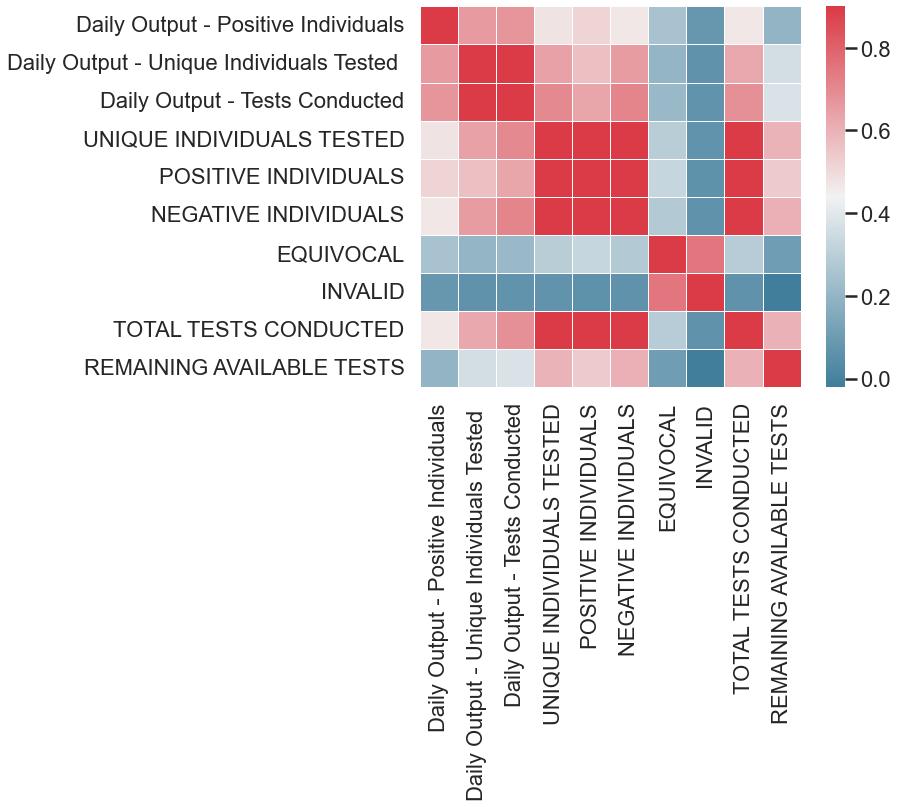

In [18]:
# Correlation heatmap

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_corr_cases.corr(), cmap=cmap, vmax=.9, square=True, linewidths=.5, ax=ax)

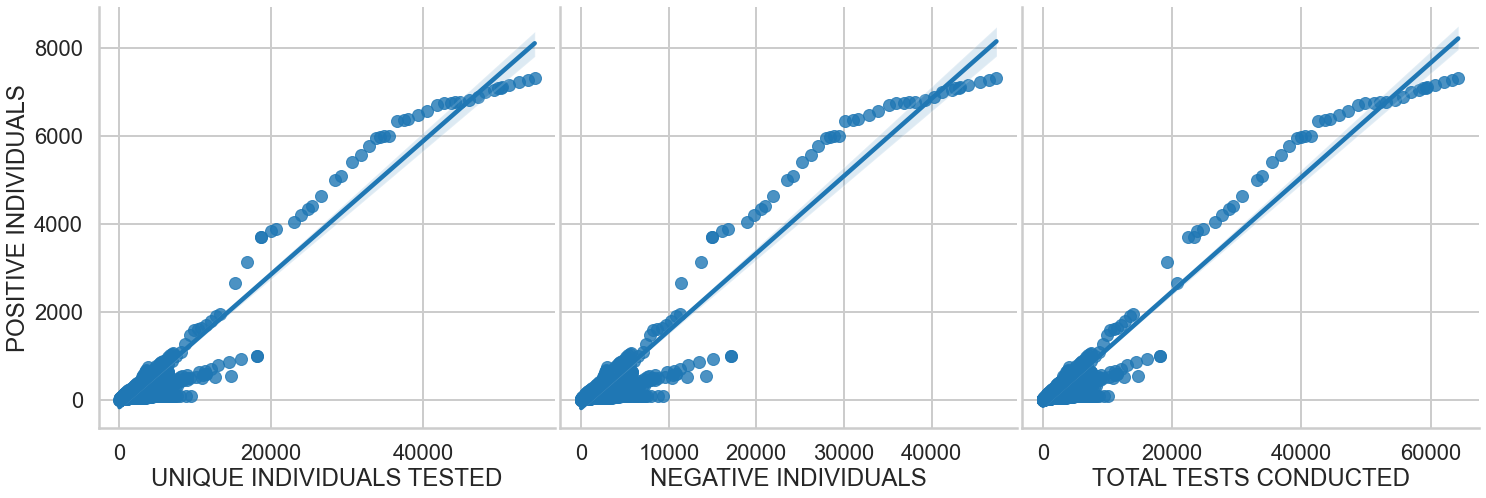

In [19]:
# visualize the relationship of the 3 predictors and positive individuals
sns.pairplot(df_corr_cases, x_vars=['UNIQUE INDIVIDUALS TESTED', 'NEGATIVE INDIVIDUALS', 'TOTAL TESTS CONDUCTED'], y_vars='POSITIVE INDIVIDUALS', height=7,aspect=1,kind='reg')

To predict the number positive individuals, we will use the predictors that scored over 90% on the correlation matrix which are: unique individuals tested, negative individuals, and total tests conducted.

In [20]:
x = df_corr_cases[['UNIQUE INDIVIDUALS TESTED', 'NEGATIVE INDIVIDUALS', 'TOTAL TESTS CONDUCTED']]
x.head(5)

,UNIQUE INDIVIDUALS TESTED,NEGATIVE INDIVIDUALS,TOTAL TESTS CONDUCTED
0,15197,11367,20826
1,473,452,478
2,115,84,193
3,672,634,672
4,332,279,335


In [21]:
y = df_corr_cases['POSITIVE INDIVIDUALS']
y.head(5)

0    2652
1      21
2      31
3      37
4      43
Name: POSITIVE INDIVIDUALS, dtype: int32

In [22]:
# separate into training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15)

In [23]:
model = LinearRegression().fit(x_train, y_train)

In [24]:
# predictions by the model
y_pred = model.predict(x_test)

In [25]:
# intercept
model.intercept_

-16.214679295941323

In [26]:
# coefficients
model.coef_

array([ 0.97031444, -0.95875753, -0.00533587])

In [27]:
# coefficient of determination (r2)
model.score(x_test, y_test)

0.9996204291538086

In [28]:
MSE = mean_squared_error(y_pred, y_test)
MSE

1014.2045322051213

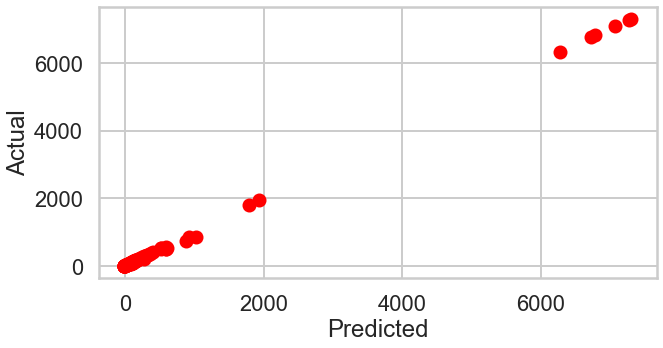

In [29]:
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, y_test, color ='r')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

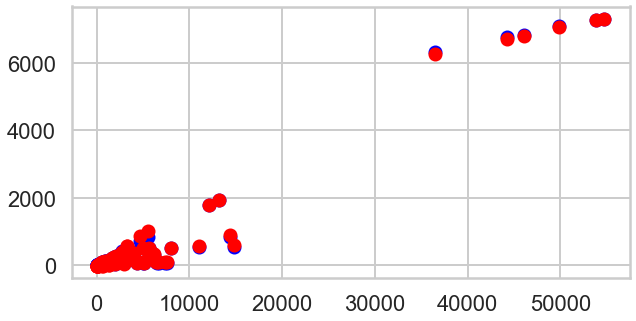

In [34]:
plt.figure(figsize=(10, 5))
plt.scatter(x_test['UNIQUE INDIVIDUALS TESTED'], y_test, color ='b')
plt.scatter(x_test['UNIQUE INDIVIDUALS TESTED'], y_pred, color ='r')
#plt.plot(y_pred, color ='k')
  
plt.show()

<b>Model: </b> -15.89 + 0.9720052(Unique Individuals Tested) - 0.96037935(Negative Individuals) - 0.00563916(Total Tests Conducted) note: changes every run of this notebook

The model was able to get 99.9% of the points within the regression line, as indicated by the coefficient of determination score. The MSE of the model is 1778.6613602289347


## Predict Number of Isolation Beds - Benjie
- use logistic regression to predict number of isolation beds
- choose which factors strongly affect isolbed_o and use thos in the regression 

## Predict Number of Surgical Masks - Pam
- use logistic regression to predict number of isolation beds
- choose which factors strongly affect isolbed_o and use thos in the regression 

## Predict Health Status of Individual - Keanna
- use Multinomial Naive Bayes classifier to classify if an individual's health status is Mild (0), Recovered (1), Asymptomatic (2), Died (3), Severe (4), or Critical (5)
- features to be used are: age, sex, home_quarantined, pregnant

Steps:
1. Separate data into features and label, clean, then encode
2. Create the multinomial classifier and fit using x_train and y_train
3. Predict
4. Evaluate

In [7]:
df_health_status.columns

Index(['case_id', 'age', 'age_group', 'sex', 'date_announced',
       'date_recovered', 'date_of_death', 'status',
       'date_announced_as_removed', 'province', 'muni_city', 'health_status',
       'home_quarantined', 'date_of_onset_of_symptoms', 'pregnant', 'region'],
      dtype='object')

In [8]:
# we have 6 classes biased towards Mild class
df_health_status.health_status.value_counts()

Mild            7777
Recovered       2460
Asymptomatic     969
Died             806
Severe            54
Critical          25
Name: health_status, dtype: int64

In [9]:
df_health_status.head(3)

,case_id,age,age_group,sex,date_announced,date_recovered,date_of_death,status,date_announced_as_removed,province,muni_city,health_status,home_quarantined,date_of_onset_of_symptoms,pregnant,region
0,C404174,38.0,35 to 39,Female,2020-01-30,NaN,NaN,Recovered,2020-02-07,Negros Oriental,Dumaguete City,Recovered,NaN,2020-01-21,NaN,Central Visayas (Region VII)
1,C462688,44.0,40 to 44,Male,2020-02-03,NaN,2020-02-01,Died,2020-02-02,Negros Oriental,Dumaguete City,Died,NaN,2020-01-18,NaN,Central Visayas (Region VII)
2,C387710,60.0,60 to 64,Female,2020-02-05,2020-01-31,NaN,Recovered,2020-02-05,Bohol,Panglao,Recovered,No,2020-01-21,NaN,Central Visayas (Region VII)


In [10]:
features = df_health_status[['age', 'sex', 'home_quarantined', 'pregnant']]
label = df_health_status['health_status']

In [11]:
# replace NaN values with unknown
features = features.fillna("Unknown")
features

,age,sex,home_quarantined,pregnant
0,38.0,Female,Unknown,Unknown
1,44.0,Male,Unknown,Unknown
2,60.0,Female,No,Unknown
3,48.0,Male,No,Unknown
4,62.0,Male,No,Unknown
...,...,...,...,...
12086,35.0,Male,Unknown,Unknown
12087,37.0,Male,Unknown,Unknown
12088,62.0,Female,Unknown,Unknown
12089,18.0,Female,Yes,No


In [12]:
# replace unkown ages with 0
features.age = features.age.replace(["Unknown"], 0)

In [13]:
# encoding strings into numerical
le = preprocessing.LabelEncoder()
features.sex = le.fit_transform(features.sex)  # female = 0, male = 1
features.home_quarantined = le.fit_transform(features.home_quarantined) # Unknown = 1, No = 0, Yes = 2
features.pregnant = le.fit_transform(features.pregnant) # Unknown = 1, No = 0, Yes = 2

In [14]:
features

,age,sex,home_quarantined,pregnant
0,38.0,0,1,1
1,44.0,1,1,1
2,60.0,0,0,1
3,48.0,1,0,1
4,62.0,1,0,1
...,...,...,...,...
12086,35.0,1,1,1
12087,37.0,1,1,1
12088,62.0,0,1,1
12089,18.0,0,2,0


In [15]:
# split data into trianing and testing
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = 0.15)

In [16]:
x_train

,age,sex,home_quarantined,pregnant
11668,26.0,1,1,1
10352,64.0,1,2,1
8416,33.0,0,2,0
11852,61.0,1,2,1
1338,52.0,1,2,1
...,...,...,...,...
1022,68.0,1,0,1
6995,21.0,0,1,1
10464,24.0,1,1,1
1833,30.0,0,2,0


In [17]:
model_nb = MultinomialNB().fit(x_train, y_train)

In [18]:
y_pred_nb = model_nb.predict(x_test)
y_pred_nb

array(['Mild', 'Mild', 'Mild', ..., 'Mild', 'Mild', 'Mild'], dtype='<U12')

In [19]:
accuracy_score(y_test, y_pred_nb)

0.6207276736493936

In [20]:
# all scores are the same
precision_recall_fscore_support(y_test, y_pred_nb, average='micro')

(0.6207276736493936, 0.6207276736493936, 0.6207276736493936, None)

In [21]:
cm = confusion_matrix(y_test, y_pred_nb, labels=["Mild", "Recovered", "Asymptomatic", "Died", "Severe", "Critical"])
cm

array([[1126,    0,    0,    0,    0,    0],
       [ 393,    0,    0,    0,    0,    0],
       [ 155,    0,    0,    0,    0,    0],
       [ 130,    0,    0,    0,    0,    0],
       [   9,    0,    0,    0,    0,    0],
       [   1,    0,    0,    0,    0,    0]], dtype=int64)

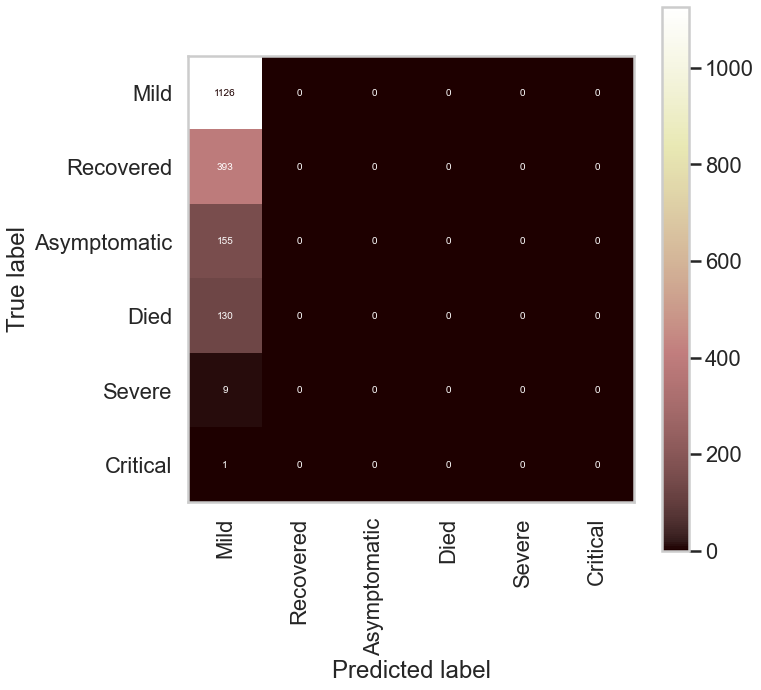

In [22]:
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mild", "Recovered", "Asymptomatic", "Died", "Severe", "Critical"])
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(False)
display.plot(ax=ax, xticks_rotation="vertical", cmap="pink")

Since the performance emtrics values are low, we will try yo create a classifier by using age_group instead of age.

In [23]:
# if using age groups
features_2 = df_health_status[['age_group', 'sex', 'home_quarantined', 'pregnant']]
features_2 = features_2.fillna("Unknown")
features_2.age_group = features_2.age_group.replace(["Unknown"], "0")

features_2.age_group = le.fit_transform(features_2.age_group)
features_2.sex = le.fit_transform(features_2.sex)  # female = 0, male = 1
features_2.home_quarantined = le.fit_transform(features_2.home_quarantined) # Unknown = 1, No = 0, Yes = 2
features_2.pregnant = le.fit_transform(features_2.pregnant) # Unknown = 1, No = 0, Yes = 2

# split data into trianing and testing
x_train1, x_test1, y_train1, y_test1 = train_test_split(features, label, test_size = 0.15)

In [24]:
new_model = MultinomialNB().fit(x_train1, y_train1)

In [25]:
new_y_pred = new_model.predict(x_test1)
accuracy_score(y_test1, new_y_pred)

0.6289966923925028

In [26]:
precision_recall_fscore_support(y_test1, new_y_pred, average='micro')

(0.6289966923925028, 0.6289966923925028, 0.6289966923925028, None)

Grouping the individuals by age doesn't improve the model by much, so we will stick with separating the individuals by their exact age and trying out the ComplementNB classifier. --> worse performance 

Try undersampling and oversampling so that minority classes are bigger and majority class samples are smaller

In [27]:
smote_enn = SMOTETomek(sampling_strategy='not majority', random_state=0)
x_resampled, y_resampled = smote_enn.fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

[('Asymptomatic', 6366), ('Critical', 6389), ('Died', 6321), ('Mild', 6647), ('Recovered', 6397), ('Severe', 6414)]


In [28]:
sampled_model = MultinomialNB().fit(x_resampled, y_resampled)

In [29]:
sampled_y_pred = sampled_model.predict(x_test)

In [30]:
accuracy_score(y_test, sampled_y_pred)

0.45810363836824697

In [31]:
precision_recall_fscore_support(y_test, sampled_y_pred, average="micro")

(0.45810363836824697, 0.45810363836824697, 0.45810363836824697, None)